In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from math import exp, cos, sin, radians, sqrt
from collections import defaultdict

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente")


Librerías cargadas correctamente


In [5]:
# Cargar datos consolidados
data = pd.read_csv('../data/consolidated_data.csv')

# Importar funciones RMR del notebook anterior
# Parámetros y conversiones
persistence_conversion = {
    1: 0.5, 2: 2.0, 3: 6.5, 4: 15.0, 5: 25.0
}

spacing_conversion = {
    1: 10, 2: 40, 3: 130, 4: 400, 5: 800
}

def calculate_rqd_from_frequency(num_discontinuities, total_length_m):
    """Calcular RQD desde frecuencia de discontinuidades"""
    if total_length_m <= 0:
        return 0
    lambda_freq = num_discontinuities / total_length_m
    rqd = 100 * exp(-0.1 * lambda_freq) * (0.1 * lambda_freq + 1)
    return max(0, min(100, rqd))

# Funciones de rating RMR (simplificadas)
def get_rqd_rating(rqd):
    if rqd >= 90: return 20
    elif rqd >= 75: return 17
    elif rqd >= 50: return 13
    elif rqd >= 25: return 8
    else: return 3

def get_spacing_rating(spacing_mm):
    if spacing_mm >= 2000: return 20
    elif spacing_mm >= 600: return 15
    elif spacing_mm >= 200: return 10
    elif spacing_mm >= 60: return 8
    else: return 5

def get_discontinuity_condition_rating(aperture_code, roughness_code, weathering_code, infilling_code):
    base_rating = 30
    aperture_penalty = (aperture_code - 1) * 2
    roughness_penalty = (roughness_code - 1) * 1.5
    weathering_penalty = (weathering_code - 1) * 3
    infilling_penalty = 0 if infilling_code <= 2 else (5 if infilling_code == 3 else 3)
    total_rating = base_rating - aperture_penalty - roughness_penalty - weathering_penalty - infilling_penalty
    return max(0, min(30, total_rating))

def get_groundwater_rating(groundwater_code):
    ratings = {1: 15, 2: 10, 3: 7, 4: 4, 5: 0}
    return ratings.get(groundwater_code, 7)

print("Datos cargados y funciones definidas")
print(f"Total registros: {len(data)}")
print(f"Estaciones: {data['Station'].unique()}")


Datos cargados y funciones definidas
Total registros: 60
Estaciones: [1 2 3 4]


In [6]:
# Funciones para análisis de familias de discontinuidades

def calculate_angular_distance(dip_dir1, dip_dir2):
    """
    Calcula la distancia angular entre dos orientaciones de Dip Direction
    Considera la naturaleza circular de los ángulos (0° = 360°)
    """
    diff = abs(dip_dir1 - dip_dir2)
    return min(diff, 360 - diff)

def identify_families(orientations, tolerance=15, min_members=3):
    """
    Identifica familias de discontinuidades basado en orientaciones similares
    
    Args:
        orientations: Lista de Dip Directions
        tolerance: Tolerancia angular en grados (±15° por defecto)
        min_members: Número mínimo de miembros por familia
    
    Returns:
        Lista de familias (cada familia es una lista de índices)
    """
    n = len(orientations)
    visited = [False] * n
    families = []
    
    for i in range(n):
        if visited[i]:
            continue
            
        # Iniciar nueva familia
        current_family = [i]
        visited[i] = True
        
        # Buscar miembros similares
        for j in range(i + 1, n):
            if visited[j]:
                continue
                
            # Calcular distancia angular promedio con la familia actual
            distances = [calculate_angular_distance(orientations[i], orientations[j]) 
                        for i in current_family]
            avg_distance = np.mean(distances)
            
            if avg_distance <= tolerance:
                current_family.append(j)
                visited[j] = True
        
        # Solo guardar familias con suficientes miembros
        if len(current_family) >= min_members:
            families.append(current_family)
    
    return families

def analyze_family_properties(df_family):
    """
    Analiza las propiedades estadísticas de una familia de discontinuidades
    """
    properties = {
        'Count': len(df_family),
        'Dip_Direction_mean': df_family['Dip_Direction_degrees'].mean(),
        'Dip_Direction_std': df_family['Dip_Direction_degrees'].std(),
        'Spacing_code_mean': df_family['Spacing_mm'].mean(),
        'Persistence_code_mean': df_family['Persistence_m'].mean(),
        'Aperture_code_mean': df_family['Aperture_mm'].mean(),
        'Roughness_code_mean': df_family['Roughness'].mean(),
        'Weathering_code_mean': df_family['Weathering'].mean(),
        'Infilling_code_mean': df_family['Infilling_Type'].mean(),
        'Groundwater_code_mean': df_family['Groundwater'].mean()
    }
    
    return properties

def calculate_family_rmr(family_properties, station_length):
    """
    Calcula RMR específico para una familia de discontinuidades
    """
    # Parámetro 1: Resistencia (constante)
    rating_strength = 7  # R4 - 75 MPa
    
    # Parámetro 2: RQD (basado en frecuencia de la familia)
    family_frequency = family_properties['Count'] / station_length if station_length > 0 else 0
    family_rqd = calculate_rqd_from_frequency(family_properties['Count'], station_length)
    rating_rqd = get_rqd_rating(family_rqd)
    
    # Parámetro 3: Espaciado (convertir código a mm)
    spacing_mm = spacing_conversion.get(int(family_properties['Spacing_code_mean']), 130)
    rating_spacing = get_spacing_rating(spacing_mm)
    
    # Parámetro 4: Condiciones de discontinuidades
    rating_conditions = get_discontinuity_condition_rating(
        family_properties['Aperture_code_mean'],
        family_properties['Roughness_code_mean'],
        family_properties['Weathering_code_mean'],
        family_properties['Infilling_code_mean']
    )
    
    # Parámetro 5: Agua subterránea
    rating_groundwater = get_groundwater_rating(int(family_properties['Groundwater_code_mean']))
    
    # Ajuste por orientación (simplificado)
    orientation_adjustment = -5
    
    # RMR total
    rmr_total = (rating_strength + rating_rqd + rating_spacing + 
                rating_conditions + rating_groundwater + orientation_adjustment)
    
    return {
        'RQD_family': family_rqd,
        'Spacing_mm': spacing_mm,
        'RMR_total': rmr_total,
        'Rating_breakdown': {
            'Strength': rating_strength,
            'RQD': rating_rqd,
            'Spacing': rating_spacing,
            'Conditions': rating_conditions,
            'Groundwater': rating_groundwater,
            'Orientation': orientation_adjustment
        }
    }

print("Funciones de análisis de familias definidas")


Funciones de análisis de familias definidas


In [7]:
# Análisis de familias por estación

all_families_results = {}

for station in data['Station'].unique():
    print(f"\n{'='*50}")
    print(f"ANÁLISIS ESTACIÓN {station}")
    print(f"{'='*50}")
    
    # Filtrar datos de la estación
    df_station = data[data['Station'] == station].copy()
    
    # Solo analizar datos con Dip_Direction válido
    df_valid = df_station.dropna(subset=['Dip_Direction_degrees']).copy()
    
    if len(df_valid) < 3:
        print(f"Datos insuficientes para análisis de familias (solo {len(df_valid)} registros)")
        continue
    
    # Obtener orientaciones
    orientations = df_valid['Dip_Direction_degrees'].tolist()
    station_length = df_station['Distance_m'].max()
    
    # Identificar familias
    families = identify_families(orientations, tolerance=15, min_members=3)
    
    print(f"Registros válidos: {len(df_valid)}")
    print(f"Familias identificadas: {len(families)}")
    
    # Analizar cada familia
    families_info = []
    
    for i, family_indices in enumerate(families):
        family_name = f"F{i+1}"
        
        # Obtener datos de la familia
        df_family = df_valid.iloc[family_indices].copy()
        
        # Analizar propiedades
        properties = analyze_family_properties(df_family)
        
        # Calcular RMR específico
        rmr_results = calculate_family_rmr(properties, station_length)
        
        # Combinar resultados
        family_info = {
            'Family': family_name,
            'Station': station,
            **properties,
            **rmr_results
        }
        
        families_info.append(family_info)
        
        # Mostrar resultados
        print(f"\n{family_name}:")
        print(f"  • Miembros: {properties['Count']}")
        print(f"  • Dip Direction: {properties['Dip_Direction_mean']:.1f}° (±{properties['Dip_Direction_std']:.1f}°)")
        print(f"  • RMR Familia: {rmr_results['RMR_total']}")
        print(f"  • RQD Familia: {rmr_results['RQD_family']:.1f}%")
        print(f"  • Espaciado: {rmr_results['Spacing_mm']:.1f} mm")
    
    # Guardar resultados de la estación
    all_families_results[station] = families_info
    
    # Análisis de discontinuidades no agrupadas
    grouped_indices = [idx for family in families for idx in family]
    ungrouped_indices = [i for i in range(len(df_valid)) if i not in grouped_indices]
    
    if ungrouped_indices:
        print(f"\nDiscontinuidades no agrupadas: {len(ungrouped_indices)}")
        ungrouped_orientations = df_valid.iloc[ungrouped_indices]['Dip_Direction_degrees'].tolist()
        print(f"Orientaciones: {[f'{o:.0f}°' for o in ungrouped_orientations[:5]]}" + 
              (f" + {len(ungrouped_orientations)-5} más" if len(ungrouped_orientations) > 5 else ""))

print(f"\n{'='*60}")
print("RESUMEN ANÁLISIS DE FAMILIAS COMPLETADO")



ANÁLISIS ESTACIÓN 1
Registros válidos: 15
Familias identificadas: 3

F1:
  • Miembros: 6
  • Dip Direction: 242.5° (±8.6°)
  • RMR Familia: 65.66666666666667
  • RQD Familia: 96.7%
  • Espaciado: 400.0 mm

F2:
  • Miembros: 4
  • Dip Direction: 220.5° (±4.1°)
  • RMR Familia: 66.0
  • RQD Familia: 98.5%
  • Espaciado: 400.0 mm

F3:
  • Miembros: 3
  • Dip Direction: 315.3° (±5.5°)
  • RMR Familia: 65.5
  • RQD Familia: 99.1%
  • Espaciado: 400.0 mm

Discontinuidades no agrupadas: 2
Orientaciones: ['80°', '271°']

ANÁLISIS ESTACIÓN 2
Registros válidos: 15
Familias identificadas: 1

F1:
  • Miembros: 4
  • Dip Direction: 268.5° (±2.6°)
  • RMR Familia: 65.0
  • RQD Familia: 99.2%
  • Espaciado: 400.0 mm

Discontinuidades no agrupadas: 11
Orientaciones: ['307°', '190°', '239°', '348°', '230°'] + 6 más

ANÁLISIS ESTACIÓN 3
Registros válidos: 15
Familias identificadas: 2

F1:
  • Miembros: 3
  • Dip Direction: 353.3° (±2.9°)
  • RMR Familia: 62.83333333333333
  • RQD Familia: 99.3%
  • Esp

In [8]:
# Crear DataFrame consolidado de todas las familias
all_families_df = []

for station, families_list in all_families_results.items():
    for family_info in families_list:
        family_data = {
            'Station': station,
            'Family': family_info['Family'], 
            'Count': family_info['Count'],
            'Dip_Direction_mean': family_info['Dip_Direction_mean'],
            'Dip_Direction_std': family_info['Dip_Direction_std'],
            'RMR_total': family_info['RMR_total'],
            'RQD_family': family_info['RQD_family'],
            'Spacing_mm': family_info['Spacing_mm']
        }
        all_families_df.append(family_data)

df_families = pd.DataFrame(all_families_df)

print("TABLA CONSOLIDADA DE FAMILIAS:")
print("="*50)
if not df_families.empty:
    print(df_families.to_string(index=False))
    
    print(f"\n\nRESUMEN ESTADÍSTICO:")
    print(f"Total familias identificadas: {len(df_families)}")
    print(f"RMR promedio familias: {df_families['RMR_total'].mean():.1f}")  
    print(f"RMR mínimo: {df_families['RMR_total'].min()}")
    print(f"RMR máximo: {df_families['RMR_total'].max()}")
    print(f"Miembros promedio por familia: {df_families['Count'].mean():.1f}")
else:
    print("No se identificaron familias suficientes para el análisis")


TABLA CONSOLIDADA DE FAMILIAS:
 Station Family  Count  Dip_Direction_mean  Dip_Direction_std  RMR_total  RQD_family  Spacing_mm
       1     F1      6          242.500000           8.619745  65.666667   96.732404         400
       1     F2      4          220.500000           4.123106  66.000000   98.456276         400
       1     F3      3          315.333333           5.507571  65.500000   99.104563         400
       2     F1      4          268.500000           2.645751  65.000000   99.216557         400
       3     F1      3          353.333333           2.886751  62.833333   99.269272         400
       3     F2      3          146.000000           1.732051  69.833333   99.269272         400
       4     F1      5          244.400000           4.929503  78.900000   97.795832         800
       4     F2      5          266.000000           3.240370  80.500000   97.795832         800
       4     F3      5           40.200000           3.420526  78.500000   97.795832         800

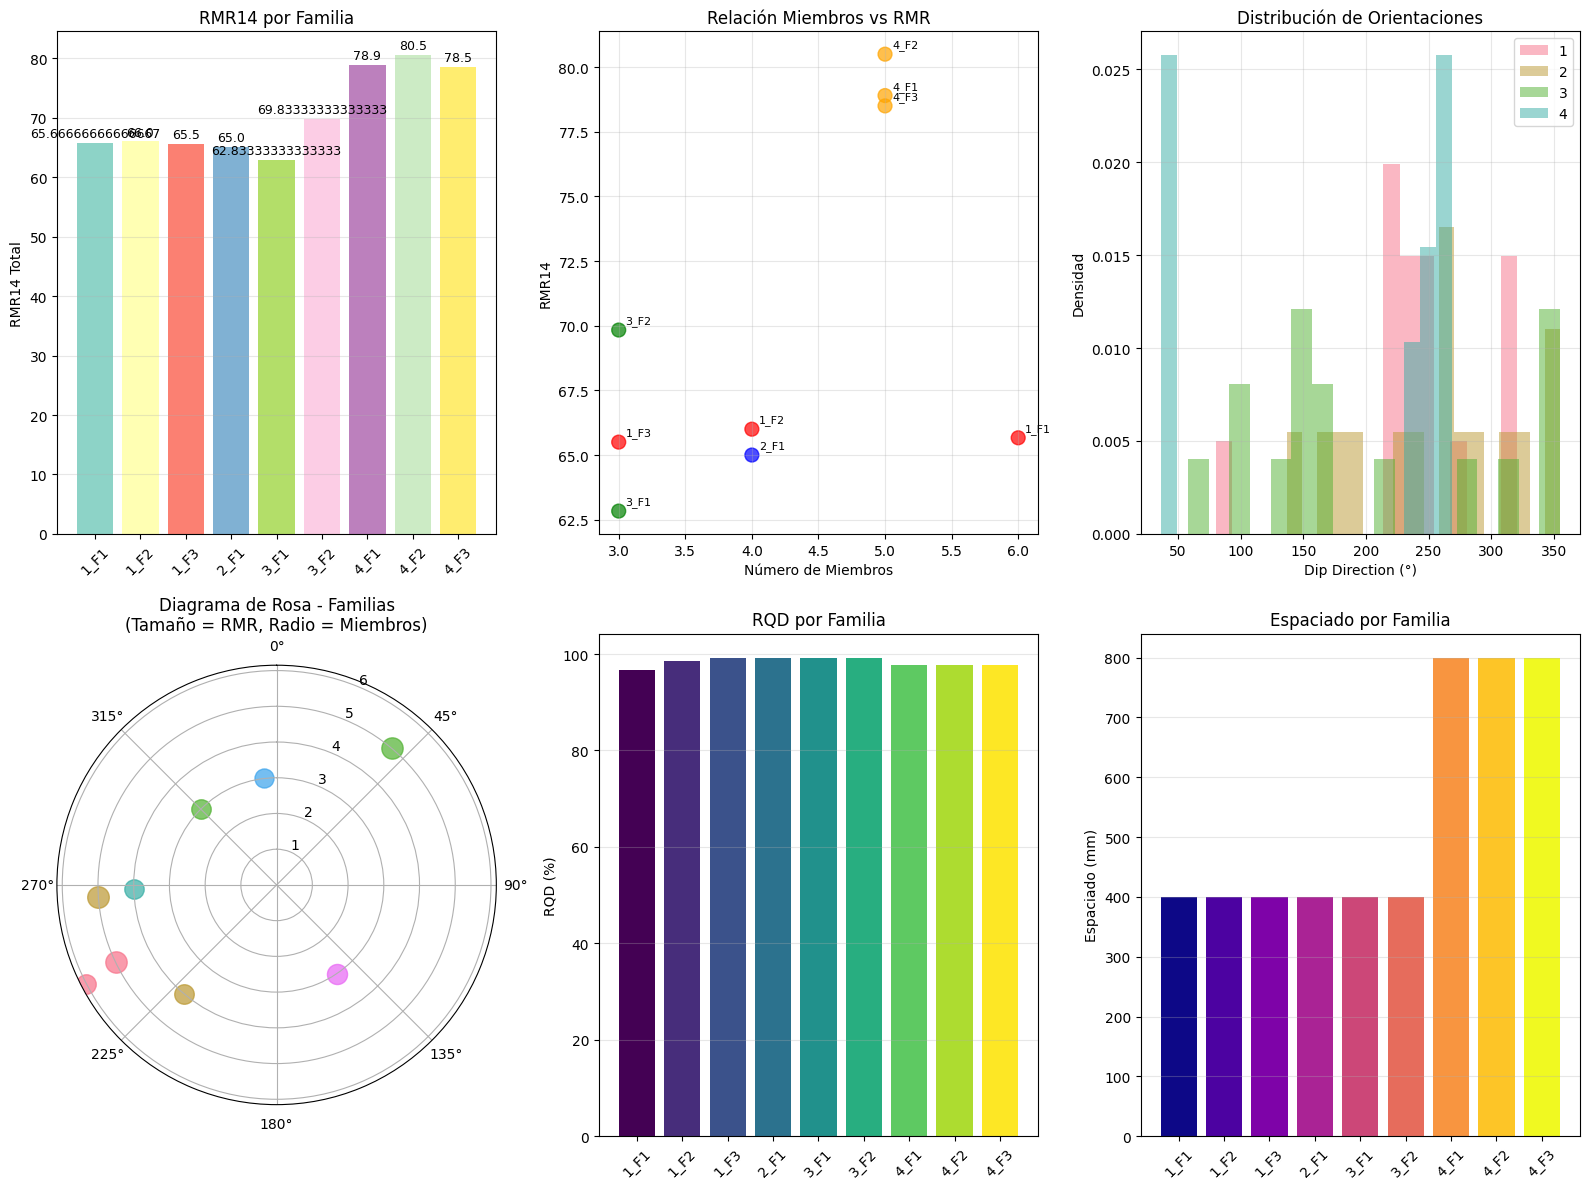


COMPARACIÓN FAMILIAS vs ESTACIÓN PROMEDIO

Estación 1:
  RMR Estación (promedio): 63.1
  RMR F1: 65.66666666666667 (6 miembros)
  RMR F2: 66.0 (4 miembros)
  RMR F3: 65.5 (3 miembros)

Estación 2:
  RMR Estación (promedio): 64.2
  RMR F1: 65.0 (4 miembros)

Estación 3:
  RMR Estación (promedio): 61.8
  RMR F1: 62.83333333333333 (3 miembros)
  RMR F2: 69.83333333333333 (3 miembros)

Estación 4:
  RMR Estación (promedio): 76.3
  RMR F1: 78.9 (5 miembros)
  RMR F2: 80.5 (5 miembros)
  RMR F3: 78.5 (5 miembros)


In [10]:
# Visualizaciones del análisis de familias

if not df_families.empty:
    # Configurar subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Gráfico de barras: RMR por familia
    ax1 = plt.subplot(2, 3, 1)
    df_families['Family_Station'] = df_families['Station'].astype(str) + '_' + df_families['Family']
    bars = ax1.bar(df_families['Family_Station'], df_families['RMR_total'], 
                   color=plt.cm.Set3(np.linspace(0, 1, len(df_families))))
    ax1.set_ylabel('RMR14 Total')
    ax1.set_title('RMR14 por Familia')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores sobre las barras
    for bar, value in zip(bars, df_families['RMR_total']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value}', ha='center', va='bottom', fontsize=9)
    
    # 2. Scatter: Número de miembros vs RMR
    ax2 = plt.subplot(2, 3, 2)
    colors = ['red' if s == 1 else 'blue' if s == 2 else 'green' if s == 3 else 'orange' 
              for s in df_families['Station']]
    ax2.scatter(df_families['Count'], df_families['RMR_total'], 
                c=colors, s=100, alpha=0.7)
    ax2.set_xlabel('Número de Miembros')
    ax2.set_ylabel('RMR14')
    ax2.set_title('Relación Miembros vs RMR')
    ax2.grid(True, alpha=0.3)
    
    # Añadir etiquetas
    for i, row in df_families.iterrows():
        ax2.annotate(f"{row['Station']}_{row['Family']}", 
                    (row['Count'], row['RMR_total']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Histograma de orientaciones por estación
    ax3 = plt.subplot(2, 3, 3)
    for station in data['Station'].unique():
        df_st = data[data['Station'] == station].dropna(subset=['Dip_Direction_degrees'])
        if len(df_st) > 0:
            ax3.hist(df_st['Dip_Direction_degrees'], bins=18, alpha=0.5, 
                    label=station, density=True)
    
    ax3.set_xlabel('Dip Direction (°)')
    ax3.set_ylabel('Densidad')
    ax3.set_title('Distribución de Orientaciones')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Diagrama de rosa simplificado para familias
    ax4 = plt.subplot(2, 3, 4, projection='polar')
    
    # Convertir orientaciones a radianes y plotear
    for i, row in df_families.iterrows():
        theta = np.radians(row['Dip_Direction_mean'])
        radius = row['Count']  # Usar número de miembros como radio
        ax4.scatter(theta, radius, s=row['RMR_total']*3, 
                   alpha=0.7, label=f"{row['Station']}_{row['Family']}")
    
    ax4.set_title('Diagrama de Rosa - Familias\n(Tamaño = RMR, Radio = Miembros)')
    ax4.set_theta_zero_location('N')
    ax4.set_theta_direction(-1)
    
    # 5. Comparación RQD por familia
    ax5 = plt.subplot(2, 3, 5)
    ax5.bar(df_families['Family_Station'], df_families['RQD_family'],
            color=plt.cm.viridis(np.linspace(0, 1, len(df_families))))
    ax5.set_ylabel('RQD (%)')
    ax5.set_title('RQD por Familia')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Espaciado promedio por familia
    ax6 = plt.subplot(2, 3, 6)
    ax6.bar(df_families['Family_Station'], df_families['Spacing_mm'],
            color=plt.cm.plasma(np.linspace(0, 1, len(df_families))))
    ax6.set_ylabel('Espaciado (mm)')
    ax6.set_title('Espaciado por Familia')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla comparativa final
    print("\n" + "="*80)
    print("COMPARACIÓN FAMILIAS vs ESTACIÓN PROMEDIO")
    print("="*80)
    
    # Calcular RMR promedio por estación (del análisis general)
    station_rmr = {1: 63.1, 2: 64.2, 3: 61.8, 4: 76.3}  # Valores del análisis RMR14
    
    for station in df_families['Station'].unique():
        families_in_station = df_families[df_families['Station'] == station]
        if len(families_in_station) > 0:
            print(f"\nEstación {station}:")
            print(f"  RMR Estación (promedio): {station_rmr.get(station, 'N/A')}")
            for _, fam in families_in_station.iterrows():
                print(f"  RMR {fam['Family']}: {fam['RMR_total']} ({fam['Count']} miembros)")
                
else:
    print("No hay suficientes familias para generar visualizaciones")
